# Pretraining Models

The goal of pretraining is to train the model so that it generates valid molecular structures based on as general set of compounds as possible and as large as your computer infrastructure allows. Since this step is the most time consuming step of the whole DrugEx workflow, pretrained models are already provided in this tutorial so that you do not have to repeat this step. You will find them in `jupyter/models/pretrained/` and you can also use them for any other applications. These are general models trained on currently available data sets that you can [finetune](finetuning.ipynb) to generate chemistry more closely related to your project. However, if you want to build a specific pretrained model this is where you can find out how. We will use ChEMBL 30 as an example.

First, we define some common variables and imports:

In [1]:
import pandas as pd

N_PROC = 12 # number of CPUs to use for preprocessing and encoding of data
MAX_MOLS = int(1e5) # maximum number of molecules to samble from the initial data set
USE_GPUS = (2,3,4) # list of GPU ids that will be used by the model
N_EPOCHS = 20 # Number of epochs for pretraining

Next, we also initialize the logger:

In [3]:
from utils import initLogger

initLogger('pretraining_graph.log')

/home/martin/miniconda3/envs/drugex/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And finally we load the data set and select a random sample of `MAX_MOLS` molecules (we do this to reduce computation time in this tutorial, but in practice you should use as large a set as possible):

In [2]:
smiles = pd.read_table('jupyter/data/chembl_30_ALL.smi', sep='\t', header=0, usecols=('Smiles',)).squeeze('columns').sample(MAX_MOLS)
smiles.shape

(100000,)

And we standardize the molecules as well:

In [4]:
from drugex.data.processing import Standardization

standardizer = Standardization(n_proc=N_PROC)
smiles = standardizer.apply(smiles)
len(smiles)

Standardizing molecules (batch processing): 100%|██████████| 3/3 [00:21<00:00,  7.32s/it]


100000

Now we should be ready to start pretraining. For most models in DrugEx, pretraining works in a similar way, but we will still show the process and results for all of them here.

## Pretraining the Graph-Based Transformer

As usual, we start with the graph-based model and we initialize the data sets just like we shown in [the previous tutorial](datasets.ipynb):

In [5]:
from drugex.data.datasets import GraphFragDataSet
import os

graph_input_folder = "data/sets/graph/pretraining"
if not os.path.exists(graph_input_folder):
    os.makedirs(graph_input_folder)

train = GraphFragDataSet(f"{graph_input_folder}/chembl30_train.tsv", rewrite=True)
test = GraphFragDataSet(f"{graph_input_folder}/chembl30_test.tsv", rewrite=True)

In [6]:
from drugex.data.fragments import FragmentCorpusEncoder
from drugex.data.fragments import GraphFragmentEncoder, FragmentPairsSplitter
from drugex.molecules.converters.fragmenters import Fragmenter
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph(n_frags=4)
encoder = FragmentCorpusEncoder(
    fragmenter=Fragmenter(4, 4, 'brics'),
    encoder=GraphFragmentEncoder(
        vocabulary
    ),
    pairs_splitter=FragmentPairsSplitter(0.1, 1000, make_unique=False),
    n_proc=N_PROC,
    chunk_size=500
)

encoder.apply(smiles, encodingCollectors=[test, train])

Creating fragment-molecule pairs (batch processing): 100%|██████████| 5/5 [02:08<00:00, 25.64s/it]
Encoding fragment-molecule pairs. (batch processing): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]
Encoding fragment-molecule pairs. (batch processing): 100%|██████████| 28/28 [02:53<00:00,  6.21s/it]


In the end, we initialize the model itself and the model monitor (just like during [finetuning](finetuning.ipynb)):

In [7]:
from drugex.training.models.transform.gpt2graph import GraphModel
from drugex.data.corpus.vocabulary import VocGraph
from drugex.training.monitors import FileMonitor

vocabulary = VocGraph(n_frags=4)
model = GraphModel(voc_trg=vocabulary, use_gpus=USE_GPUS)
monitor = FileMonitor(f'data/models/pretrained/graph/chembl_sample_{MAX_MOLS}', verbose=True)

And we start fitting the model:

In [8]:
model.fit(train.asDataLoader(512), test.asDataLoader(512), monitor=monitor, epochs=N_EPOCHS)

100%|██████████| 20/20 [5:17:32<00:00, 952.63s/it]  


As you can see for the current setup, this should take a few hours, but you should be able to see at least some results at the end.

Because we used the `FileMonitor`, it is now fairly easy to observe model performance data:

In [9]:
df_info = pd.read_table(monitor.outDF)
df_info

,epoch,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,7.208749,1.0,NaN,NaN,3.427143
1,2,5.429379,1.0,NaN,NaN,1.122359
2,3,4.278054,1.0,NaN,NaN,0.889368
3,4,3.808451,1.0,NaN,NaN,0.767085
4,5,3.550602,1.0,NaN,NaN,0.698231
5,6,3.377675,1.0,NaN,NaN,0.662949
6,7,3.367232,1.0,NaN,NaN,0.641434
7,8,3.214485,1.0,NaN,NaN,0.628038
8,9,3.151674,1.0,NaN,NaN,0.614168
9,10,3.088146,1.0,NaN,NaN,0.603411


<AxesSubplot:>

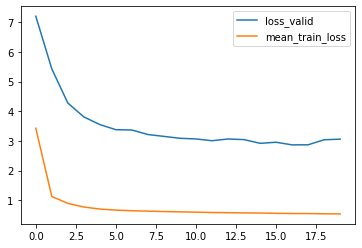

In [10]:
df_info[['loss_valid', 'mean_train_loss']].plot.line()

We can see that the loss on both validation set and training set was decreasing during training, but more or less reached a plateu after 10 epochs already.

We can also observe the validation molecules generated over time at the end of each epoch:

In [11]:
df_smiles = pd.read_table(monitor.outSmiles)
df_smiles

,SMILES,Valid,Frags,Epoch
0,O=CCNCCCN1OC(F)CCC1c1cccc2ccccc12,1.0,CN1CCCCO1.c1ccc2ccccc2c1,1
1,C=C1CC=CCC=CCC2=CC(c3ncsn3)OC(C=O)OC=C(C1)CC(C...,1.0,Cn1cccn1.c1ncsn1,1
2,C1=C2NC(c3ccc4ncccc4c3-c3ccc4[nH]cnc4c3)CNC12,1.0,C1CNCCN1.c1ccc2[nH]cnc2c1.c1ccc2ncccc2c1,1
3,Fc1ccc(Cc2ccncn2)c(F)c1,1.0,Fc1cccc(F)c1.c1cncnc1,1
4,CC1CNN=NNC=CC1C1C(=CN([O-])C2CCCCN2)C1C(=O)O,1.0,C1CC1.C1CCNCC1,1
...,...,...,...,...
45535,Cc1cc(C)nc(N=C(N)NOc2cccc(C)c2Cl)n1,1.0,Cc1cc(C)nc(N=C(N)N)n1.Cc1ccccc1Cl,20
45536,CCC1=C(C(C)(C)C(C)=O)C(C)C(C2=Nc3cccc(c3)CC=NC...,1.0,CC=O.NC=O,20
45537,COc1ccc(C2NC(=O)C(c3nccc(C)n3)S2)cc1NC(=O)c1cc...,1.0,CO.Cc1ccncn1.Fc1ccccc1.O=C1CSCN1,20
45538,CCC(CNC(=O)c1cc(F)ccc1-c1c(F)ccc(-c2cnc(N(C)CO...,1.0,Fc1cccc(F)c1.c1cncnc1,20


In [ ]:
from utils import smilesToGrid

smilesToGrid(df_smiles[df_smiles['Epoch'] % 5 == 0]['SMILES']) # display only molecules generated every 5th epoch

Depending on the `MAX_MOLS` parameter and `N_EPOCHS`, we should see the structures of molecules improving over time in their chemical viability and diversity.

We can also load and test the pretrained model by generating compounds with it directly:

In [13]:
from drugex.training.models.transform.gpt2graph import GraphModel

pretrained = GraphModel(voc_trg=vocabulary, use_gpus=USE_GPUS)
pretrained.loadStatesFromFile(f'{monitor.path}.pkg')

In [14]:
inputs = [
    "c1ccncc1CC2CC2",
    "CC2CC2",
]

smiles, frags = pretrained.sampleFromSmiles(inputs, min_samples=30)
set(frags)

Standardizing molecules (batch processing): 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]
Creating fragment-molecule pairs (batch processing): 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]
Encoding fragment-molecule pairs. (batch processing): 100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


{'C1CC1', 'C1CC1.c1ccncc1', 'c1ccncc1'}

In [15]:
smilesToGrid(smiles)

Again, based on the intensity of training and the size of the sampled data set, these compounds should look more or less plausible.